In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feather
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from collections import defaultdict
from bitarray import bitarray
import networkx as nx
from scipy import signal
from numba import jit
from functools import partial

import riiideducation
tqdm_notebook.pandas(desc="progress: ")

pd.set_option("max_rows", 1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def init_dict():
    ans = [0] * 42
    return np.array(ans)

user_community_count_dict = defaultdict(init_dict)
user_community_count_dict[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [3]:
DIR ="../input/riiid-test-answer-prediction/"
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")
train = pd.read_feather("../input/riid-train/train.feather")
addtional_q = pd.read_csv("../input/riiid-question-clustering/question_cmnts.csv")

In [4]:
questions["community"] = addtional_q['community']

In [5]:
#import pickle
#with open('../input/riiid-question-clustering/ql_community.pickle', 'rb') as f:
#    ql_community = pickle.load(f)

In [6]:
community_num = questions["community"].nunique()
community_num

76

# train
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before  seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

- content_type_id = 0なら、questions.csvと結合できる, content_type_id = 1なら、lectures.csvと結合できる

In [7]:
train.drop(["row_id", "content_type_id", "task_container_id", "user_answer",], axis=1, inplace=True) #"prior_question_had_explanation", "prior_question_elapsed_time"

In [8]:
#train["ql_community"] = ql_community

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 6 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   timestamp                       uint64
 1   user_id                         uint32
 2   content_id                      uint16
 3   answered_correctly              int8  
 4   prior_question_elapsed_time     uint32
 5   prior_question_had_explanation  object
dtypes: int8(1), object(1), uint16(1), uint32(2), uint64(1)
memory usage: 2.5+ GB


In [10]:
train.describe()

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08
mean,7.703644e+09,1.076732e+09,5.219605e+03,6.251644e-01,9.979512e+07
std,1.159266e+10,6.197163e+08,3.866359e+03,5.225307e-01,6.469552e+08
min,0.000000e+00,1.150000e+02,0.000000e+00,-1.000000e+00,0.000000e+00
25%,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.600000e+04
50%,2.674234e+09,1.071781e+09,5.026000e+03,1.000000e+00,2.100000e+04
75%,9.924551e+09,1.615742e+09,7.425000e+03,1.000000e+00,3.066600e+04
max,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,4.294967e+09


In [11]:
lecture_count_dict = train[train["answered_correctly"] == -1]["content_id"].value_counts().reset_index(drop=False)
lecture_count_dict.columns = ["content_id", "lecture_count"]
lecture_count_dict = lecture_count_dict.set_index("content_id")
remain_lecture = list(set(lectures.lecture_id) -set(lecture_count_dict.index))
lecture_count_dict = lecture_count_dict.to_dict()
for i in remain_lecture:
    lecture_count_dict[i] = 0
lecture_count_dict

{'lecture_count': {3153: 37024,
  21411: 27051,
  10540: 24312,
  29695: 24126,
  15888: 22627,
  27845: 21250,
  26335: 21118,
  32312: 20943,
  29544: 20941,
  18545: 19167,
  14325: 19004,
  9896: 18498,
  8317: 18297,
  21887: 17988,
  5694: 17808,
  5752: 16970,
  14443: 16650,
  335: 16332,
  8330: 16081,
  28621: 15093,
  25843: 14915,
  8708: 14640,
  10852: 14503,
  24985: 14199,
  6808: 14137,
  29579: 14095,
  9758: 13634,
  7949: 13210,
  24697: 13074,
  22034: 13069,
  22089: 12900,
  24908: 12877,
  4425: 12840,
  15430: 12616,
  17326: 12494,
  4057: 12421,
  27339: 12184,
  12472: 12038,
  7926: 11812,
  19744: 11624,
  18186: 11557,
  12638: 11527,
  7477: 11482,
  8976: 11388,
  1105: 11334,
  27022: 11236,
  484: 11198,
  26516: 11187,
  23336: 11183,
  13605: 11182,
  25401: 11180,
  18239: 11102,
  22362: 11043,
  6797: 11015,
  28921: 11006,
  27115: 11000,
  16034: 10922,
  8207: 10853,
  1501: 10822,
  31589: 10785,
  12811: 10768,
  17124: 10716,
  89: 10695,
 

In [12]:
train.head(100)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,1,4294967295,None
1,56943,115,5716,1,37000,False
2,118363,115,128,1,55000,False
3,131167,115,7860,1,19000,False
4,137965,115,7922,1,11000,False
5,157063,115,156,1,5000,False
6,176092,115,51,1,17000,False
7,194190,115,50,1,17000,False
8,212463,115,7896,1,16000,False
9,230983,115,7863,1,16000,False


In [13]:
len(train.content_id.unique())

13782

In [14]:
lec_index = list(train[train["answered_correctly"]==-1].index)

In [15]:
# accuracy before lecture
lec_before_index = [i-1 for i in lec_index] 
train[(train.index.isin(lec_before_index)) & (train["answered_correctly"]!=-1)]["answered_correctly"].mean(), train[(train.index.isin(lec_before_index)) & (train["answered_correctly"]!=-1)].shape[0]

(0.4478886725540279, 1907023)

In [16]:
# overall accuracy mean
train[train["answered_correctly"] != -1]["answered_correctly"].mean()

0.6572355454194717

In [17]:
# accuracy after lecture
lec_after_index = [i+1 for i in lec_index] 
train[(train.index.isin(lec_after_index)) & (train["answered_correctly"]!=-1)]["answered_correctly"].mean(), train[(train.index.isin(lec_after_index)) & (train["answered_correctly"]!=-1)].shape[0]

(0.7273451867124833, 1907023)

In [18]:
len(lec_after_index), len(lec_before_index)

(1959032, 1959032)

In [19]:
train.content_id.value_counts().head()

6116    213605
6173    202106
4120    199372
175     195861
7876    190170
Name: content_id, dtype: int64

In [20]:
# null value in prior_question_had_explanation_only, but other variables include -1 as missing value in user_answer and answered_correctly
train.isnull().sum()

timestamp                              0
user_id                                0
content_id                             0
answered_correctly                     0
prior_question_elapsed_time            0
prior_question_had_explanation    392506
dtype: int64

In [21]:
train['prior_question_had_explanation'].fillna(False, inplace=True)

In [22]:
mod_train = train[train["answered_correctly"] != -1].reset_index(drop=True).copy()

In [23]:
mod_train.shape

(99271300, 6)

In [24]:
#user_learning_time = train.drop_duplicates(["user_id","timestamp"])[["timestamp", "user_id"]].copy().reset_index(drop=True)
#user_learning_time["blank"] = user_learning_time.groupby("user_id")["timestamp"].diff()
#user_learning_time["blank"] -= 1
#user_learning_time["blank"] = user_learning_time["blank"].fillna(0)
#train = train.merge(user_learning_time, on=["user_id", "timestamp"])
#train.groupby("blank")["answered_correctly"].agg(["std"]).plot()
#train.groupby("blank")["answered_correctly"].agg(["mean"]).plot()
#train["mod_blank"] = train["blank"].apply(lambda x: 1 if x <=5 else 0)
#train.groupby("mod_blank")["answered_correctly"].agg(["mean"]).plot()

In [25]:
# from atma
#tmp = user_learning_time[user_learning_time.user_id==115].copy()
#tmp["cont_logdays"] = tmp.timestamp.diff().ne(1).cumsum()
#tmp["cont_logdays"] = tmp.groupby(['cont_logdays']).cumcount()+1

#user_learning_time = train.drop_duplicates(["user_id","timestamp"])[["timestamp", "user_id"]].copy().reset_index(drop=True)
#user_learning_time["new_blank"] = user_learning_time.groupby("user_id")["timestamp"].diff().ne(1).cumsum()
#user_learning_time["new_blank"] = user_learning_time.groupby(["user_id", 'new_blank']).cumcount()+1
#user_learning_time.head()

In [26]:
# data num per user_id
#train.groupby("user_id").agg("max")["task_container_id"].plot(kind="hist")

In [27]:
#train["content_type_id"].sum() / train.shape[0] # lectureはわずか2%

In [28]:
#print(train.groupby("user_id")["content_type_id"].mean().max(), train.groupby("user_id")["content_type_id"].mean().min())
#print(train.groupby("user_id")["content_type_id"].mean().mean())

In [29]:
# had explanation in almost 90%
# train["prior_question_had_explanation"].value_counts(normalize=True)

In [30]:
#train = train.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
#train = train.loc[train['answered_correctly'] != -1].reset_index(drop=True)
#tmp = train.groupby('part').agg({'answered_correctly': ['mean']}).copy()
#tmp.columns = ['correct_rate']
#tmp

In [31]:
tmp = mod_train.groupby("content_id")["answered_correctly"].mean().reset_index()
print(len(tmp[tmp.answered_correctly<0.2]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.2) & (tmp.answered_correctly<0.3)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.3) & (tmp.answered_correctly<0.4)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.4) & (tmp.answered_correctly<0.5)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.5) & (tmp.answered_correctly<0.6)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.5) & (tmp.answered_correctly<0.6)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.6) & (tmp.answered_correctly<0.7)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.7) & (tmp.answered_correctly<0.8)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.8) & (tmp.answered_correctly<0.9)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.9)]["content_id"]))

34
203
490
885
1567
1567
2520
3248
3143
1433


In [32]:
mod_train.head(100)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,1,4294967295,False
1,56943,115,5716,1,37000,False
2,118363,115,128,1,55000,False
3,131167,115,7860,1,19000,False
4,137965,115,7922,1,11000,False
5,157063,115,156,1,5000,False
6,176092,115,51,1,17000,False
7,194190,115,50,1,17000,False
8,212463,115,7896,1,16000,False
9,230983,115,7863,1,16000,False


# lecture
- lectures.csv: metadata for the lectures watched by users as they progress in their education.
- lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
- part: top level category code for the lecture.
- tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- type_of: brief description of the core purpose of the lecture

In [33]:
lectures.shape

(418, 4)

In [34]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [35]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [36]:
lectures[lectures.type_of=="solving question"]["tag"].unique()

array([ 79, 156, 134,  80, 101,  74,  43, 109, 142, 140,   1,  26, 173,
         7,  64, 141, 124, 161,   4,  94,  70, 119, 177,  54,  50, 116,
        93, 136, 127,  53, 130,  13,  36,  62, 181, 164, 163,  85,  91,
         9,  28,  98, 159,  27, 149,  61, 166,  14, 113, 182,  55,  49,
       106,  47,  60, 179,  71,  82,  44,  25, 108,  96,   5, 152,  16,
        73, 178,  42,  40,   6, 157,  33,  51, 133,  48, 167,  68,  95,
        30, 174,  20,  66,  37,  45, 105, 151, 123, 114, 180,  89, 168,
        78, 111,  52,  34,   8, 184, 176,  72, 129, 128,  65, 125, 170,
       104,  69,   0])

In [37]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [38]:
lectures.tag.min(), lectures.tag.max()

(0, 187)

In [39]:
lectures.tag.value_counts().head() # 一部タグに重複あり

136    7
116    6
134    6
27     6
161    6
Name: tag, dtype: int64

In [40]:
lectures.part.value_counts() # 一部タグに重複あり

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [41]:
lectures.type_of.value_counts() 

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [42]:
lectures.isnull().sum() # no missing value

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

In [43]:
len(lectures.lecture_id.unique())

418

In [44]:
len(set(lectures.lecture_id.unique()) & set(train.content_id.unique()))

417

In [45]:
# lecture id 28098 isn't included in training set
# set(lectures.lecture_id.unique()) - set(set(lectures.lecture_id.unique()) & set(train.content_id.unique()))

In [46]:
#lectures['type_of'] = lectures['type_of'].replace('solving question', 'solving_question')
#lectures = pd.get_dummies(lectures, columns=['part', 'type_of'])

In [47]:
#part_lectures_columns = [column for column in lectures.columns if column.startswith('part')]
#types_of_lectures_columns = [column for column in lectures.columns if column.startswith('type_of_')]

In [48]:
train_lec = train[train["answered_correctly"] == -1].reset_index(drop=True)
train_lec = train_lec.merge(lectures[["lecture_id", "tag"]], left_on="content_id", right_on="lecture_id", how="left")
train_lec.drop(["lecture_id"], axis=1, inplace=True)

In [49]:
train_lec.head()

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,tag
0,653762,2746,6808,-1,4294967295,False,129
1,10183847,5382,16736,-1,4294967295,False,40
2,1424348597,5382,30207,-1,4294967295,False,43
3,1425557777,5382,18545,-1,4294967295,False,58
4,405813029,8623,10540,-1,4294967295,False,99


In [50]:
tmp = train_lec.user_id.value_counts().reset_index(drop=False)
tmp.columns = ["user_id", "lec_num"]
tmp[tmp.lec_num>=200]

,user_id,lec_num
0,372519499,397
1,353540103,395
2,105239469,389
3,1066383521,386
4,2066672014,386
5,194669131,385
6,1109748920,379
7,499347415,377
8,1660941992,368
9,617553217,363


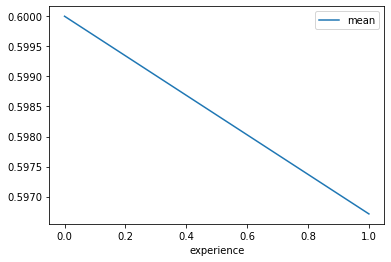

In [51]:
def calc(row):
    return len(row["tag"].intersection(row["tags"]))

user_id = 2042598372
sample_df = train[train.user_id==user_id].copy().reset_index(drop=True)

sample_df = sample_df.merge(lectures[["lecture_id", "tag"]], left_on="content_id", right_on="lecture_id", how="left")
sample_df = pd.merge(sample_df, questions[["question_id", "part", "tags"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
sample_df.drop(["question_id", "lecture_id"], axis=1, inplace=True)

sample_df["tag"] = sample_df["tag"].astype(str).replace("nan", "").cumsum()
sample_df["tag"] = sample_df["tag"].apply(lambda x: x.replace('.0', ', '))
sample_df["tag"] = sample_df["tag"].apply(lambda x: set(x))
sample_df["tags"] = sample_df["tags"].apply(lambda x: str(x).replace(' ', ', '))
sample_df["tags"] = sample_df["tags"].apply(lambda x: set(x))

sample_df = sample_df[sample_df["answered_correctly"] != -1].reset_index(drop=True)

sample_df["experience"] = sample_df.apply(calc, axis=1)
sample_df["experience"] = sample_df["experience"].apply(lambda x: 1 if x>=1 else 0)
sample_df.drop(["tag", "tags"], axis=1, inplace=True)
tmp = sample_df.groupby(["experience"])["answered_correctly"].agg(["mean"])
tmp.plot()

In [52]:
del train

# questions
- questions.csv: metadata for the questions posed to users.
- question_id: foreign key for the train/test content_id column, when the content type is question (0).
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [53]:
questions.bundle_id.max(), questions.bundle_id.min(), 

(13522, 0)

In [54]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags,community
0,0,0,0,1,51 131 162 38,0
1,1,1,1,1,131 36 81,0
2,2,2,0,1,131 101 162 92,0
3,3,3,0,1,131 149 162 29,0
4,4,4,3,1,131 5 162 38,0


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

def join(df):
    x = [str(e) for e in list(df)]
    return " ".join(x)

ids = ["tags"]

for id_ in ids:
    print(id_)
    docs = questions[questions.part==5].groupby("question_id")[id_].apply(join)
    max_features = int(questions[id_].nunique() * 0.8)
    tv = TfidfVectorizer(max_features=max_features)
    X = tv.fit_transform(docs)

    n_components = 3
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X = svd.fit_transform(X)
    df = pd.DataFrame(X, columns=[f"tfidf_{id_}_{i}" for i in range(n_components)])
    df.index = docs.index
    
kmeans = KMeans(n_clusters=4, random_state=0).fit(df.values)
df["tag_class"] = kmeans.labels_

tags


In [56]:
df = df.merge(questions, on="question_id", how="left")
df.head()

,question_id,tfidf_tags_0,tfidf_tags_1,tfidf_tags_2,tag_class,bundle_id,correct_answer,part,tags,community
0,3549,-3.965108e-15,-2.892069e-15,7.385667e-15,0,3549,1,5,8,43
1,3550,-3.283933e-16,-2.742196e-16,1.868799e-16,0,3550,1,5,8,43
2,3551,-5.334562e-16,5.354134e-16,-3.319689e-15,0,3551,0,5,8,43
3,3552,6.682521e-16,4.640026e-17,3.576192e-15,0,3552,1,5,8,43
4,3553,2.401886e-18,1.596339e-17,1.764569e-17,0,3553,3,5,8,43


In [57]:
questions[questions.question_id.isin(df[df["tag_class"]==0].question_id)]

,question_id,bundle_id,correct_answer,part,tags,community
3549,3549,3549,1,5,8,43
3550,3550,3550,1,5,8,43
3551,3551,3551,0,5,8,43
3552,3552,3552,1,5,8,43
3553,3553,3553,3,5,8,43
...,...,...,...,...,...,...
13517,13517,13517,3,5,8,43
13518,13518,13518,3,5,14,3
13519,13519,13519,3,5,8,43
13521,13521,13521,0,5,125,27


In [58]:
set(questions[questions.part==1].tags.unique()) & set(questions[questions.part==2].tags.unique())

set()

In [59]:
questions[questions.part==5].tags.value_counts()

8      697
73     512
53     417
1      348
96     330
55     287
79     272
14     211
173    196
89     191
109    177
91     113
60     103
116     78
72      68
7       61
134     61
133     58
125     56
166     55
48      51
52      50
152     50
147     49
181     45
4       43
45      42
66      41
64      40
156     40
174     39
159     37
168     36
80      32
177     32
25      27
123     26
47      25
28      24
85      23
54      23
170     23
128     22
180     22
75      21
108     20
26      20
175     19
33      18
65      18
44      18
127     17
115     17
24      16
43      16
95      15
151     13
182     12
15      12
124     12
49      12
167     11
23      10
57      10
112     10
31      10
179     10
58      10
132     10
172      9
34       6
78       6
Name: tags, dtype: int64

In [60]:
questions['tags'] = questions['tags'].apply(lambda ts: [int(x) for x in str(ts).split() if x != 'nan'])
questions.head()

,question_id,bundle_id,correct_answer,part,tags,community
0,0,0,0,1,"[51, 131, 162, 38]",0
1,1,1,1,1,"[131, 36, 81]",0
2,2,2,0,1,"[131, 101, 162, 92]",0
3,3,3,0,1,"[131, 149, 162, 29]",0
4,4,4,3,1,"[131, 5, 162, 38]",0


In [61]:
questions.shape

(13523, 6)

In [62]:
len(questions.bundle_id.unique())

9765

In [63]:
questions['tags'].apply(lambda x: len(x)).max(), questions['tags'].apply(lambda x: len(x)).min() #max: 6, min: 1

(6, 0)

In [64]:
questions.correct_answer.value_counts(normalize=True) # 2 has the smallest ratio of correct answer

0    0.274791
3    0.262072
1    0.257191
2    0.205945
Name: correct_answer, dtype: float64

In [65]:
len(questions.question_id.unique())

13523

In [66]:
#questions[questions['tags'].isna()]
questions.iloc[10033][:]

question_id       10033
bundle_id         10033
correct_answer        2
part                  6
tags                 []
community             4
Name: 10033, dtype: object

In [67]:
questions.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              0
community         0
dtype: int64

In [68]:
tag_to_questions = {}
for i, row in questions.iterrows():
    for t in row['tags']:
        if t not in tag_to_questions:
            tag_to_questions[t] = set()
        tag_to_questions[t].add(row['question_id'])
tags_df = pd.DataFrame([{'tag':t,'questions':qs}for t,qs in tag_to_questions.items()])
tags_df.head()

,tag,questions
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,..."
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ..."
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2..."
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,..."
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975..."


In [69]:
tags_df.shape, tags_df.tag.max(), tags_df.tag.min() # 188個のスキル

((188, 2), 187, 0)

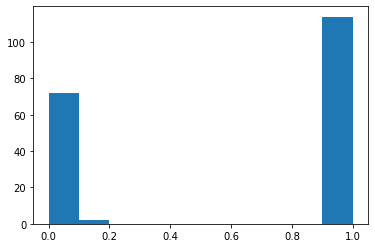

In [70]:
questions['multitag'] = questions['tags'].apply(lambda ts: len(ts)>1)

def calc_fract_multitagged(tag_row):
    tag_qs = questions[questions['question_id'].isin(tag_row['questions'])]
    return tag_qs[tag_qs['multitag']==True].size/tag_qs.size
tags_df['fraction_multitagged'] = tags_df.apply(calc_fract_multitagged, axis=1)
plt.hist(tags_df['fraction_multitagged'])
plt.show()

In [71]:
tags_df["questions_no"] = tags_df["questions"].apply(lambda x: len(x))

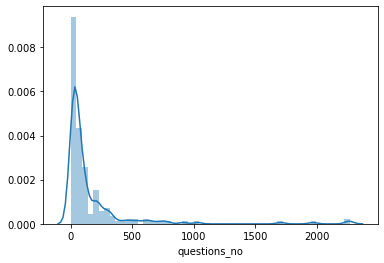

In [72]:
sns.distplot(tags_df.questions_no)

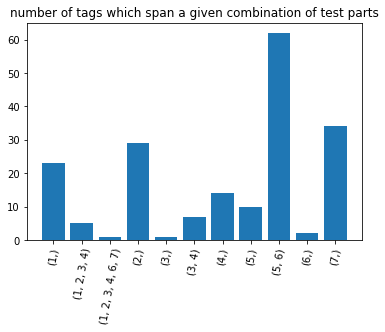

In [73]:
def calc_tag_parts(tag_row):
    tag_qs = questions[questions['question_id'].isin(tag_row['questions'])]
    return tuple(tag_qs['part'].unique())
tags_df['parts'] = tags_df.apply(calc_tag_parts, axis=1)

part_sizes = tags_df.groupby('parts').size()
plt.bar(range(len(part_sizes)), part_sizes)
plt.xticks(range(len(part_sizes)),part_sizes.index, rotation=80)
plt.title('number of tags which span a given combination of test parts')
plt.show()

In [74]:
tags_df.head(20)

,tag,questions,fraction_multitagged,questions_no,parts
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,...",1.0,71,"(1,)"
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.0,650,"(1,)"
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)"
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,...",1.0,2256,"(1, 2, 3, 4)"
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975...",1.0,35,"(1,)"
5,81,"{1, 5, 9, 11, 15, 19, 21, 25, 29, 31, 35, 37, ...",1.0,1969,"(1, 2, 3, 4)"
6,101,"{2, 12802, 12809, 138, 14, 10384, 147, 12822, ...",1.0,52,"(1,)"
7,92,"{2, 6, 8, 12, 16, 18, 22, 26, 28, 32, 34, 38, ...",1.0,2269,"(1, 2, 3, 4)"
8,149,"{128, 3, 10500, 5, 12806, 7946, 140, 7949, 128...",1.0,53,"(1,)"
9,29,"{3, 7, 13, 17, 23, 27, 43, 47, 53, 57, 73, 77,...",1.0,1707,"(1, 2, 3, 4)"


In [75]:
tags_df[tags_df.parts == (3,4)]

,tag,questions,fraction_multitagged,questions_no,parts
57,74,"{2048, 2051, 12291, 2058, 2060, 12300, 12303, ...",1.0,476,"(3, 4)"
58,136,"{12289, 2050, 2052, 12293, 2054, 2055, 2056, 2...",1.0,1033,"(3, 4)"
59,82,"{12290, 12292, 12299, 2062, 12305, 2067, 2068,...",1.0,527,"(3, 4)"
60,106,"{12288, 2049, 2069, 12312, 2075, 12315, 12318,...",1.0,457,"(3, 4)"
61,157,"{1537, 2053, 3077, 2568, 2059, 1548, 1549, 257...",1.0,206,"(3, 4)"
62,113,"{3074, 3076, 3079, 3082, 11813, 1575, 11816, 1...",1.0,156,"(3, 4)"
63,161,"{2561, 2564, 2567, 2570, 2573, 2577, 11795, 25...",1.0,146,"(3, 4)"


In [76]:
tags_df[tags_df.parts == (1,)]

,tag,questions,fraction_multitagged,questions_no,parts
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,...",1.0,71,"(1,)"
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.0,650,"(1,)"
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975...",1.0,35,"(1,)"
6,101,"{2, 12802, 12809, 138, 14, 10384, 147, 12822, ...",1.0,52,"(1,)"
8,149,"{128, 3, 10500, 5, 12806, 7946, 140, 7949, 128...",1.0,53,"(1,)"
10,5,"{4, 12805, 13, 12813, 22, 35, 12856, 12872, 75...",1.0,85,"(1,)"
11,10,"{6, 9, 19, 21, 23, 24, 25, 27, 34, 38, 39, 44,...",1.0,293,"(1,)"
12,94,"{10496, 6, 10631, 10634, 10507, 142, 10388, 10...",1.0,27,"(1,)"
13,61,"{12675, 7, 12680, 12683, 12684, 15, 18, 7954, ...",1.0,49,"(1,)"
14,110,"{12675, 7, 12680, 12683, 12684, 15, 18, 7954, ...",1.0,49,"(1,)"


In [77]:
questions[questions.question_id==11520]

,question_id,bundle_id,correct_answer,part,tags,community,multitag
11520,11520,11520,0,5,[4],2,False


In [78]:
tags_df[tags_df.fraction_multitagged == 0]

,tag,questions,fraction_multitagged,questions_no,parts
78,4,"{11520, 3969, 3970, 13440, 8198, 13324, 6414, ...",0.0,50,"(5, 6)"
79,166,"{11267, 11524, 8714, 11532, 13452, 11534, 3603...",0.0,60,"(5, 6)"
80,85,"{4992, 13320, 9100, 4114, 4755, 3609, 11420, 6...",0.0,24,"(5, 6)"
81,156,"{9094, 4999, 5001, 13450, 5004, 5006, 5007, 50...",0.0,43,"(5, 6)"
84,66,"{5508, 5509, 5892, 4363, 5518, 4367, 4368, 616...",0.0,41,"(5,)"
85,108,"{9088, 3841, 5154, 5156, 9129, 3628, 8494, 517...",0.0,20,"(5,)"
87,72,"{11266, 8453, 8455, 8456, 6028, 8461, 8465, 60...",0.0,72,"(5, 6)"
88,95,"{9283, 10211, 5702, 5704, 9289, 5614, 3632, 36...",0.0,17,"(5, 6)"
90,15,"{8640, 8641, 8642, 8643, 8644, 6661, 5615, 561...",0.0,12,"(5,)"
93,75,"{6669, 3864, 4519, 9776, 4791, 3639, 10175, 48...",0.0,23,"(5, 6)"


In [79]:
tags_df.sort_values("questions_no", ascending=False)

,tag,questions,fraction_multitagged,questions_no,parts
7,92,"{2, 6, 8, 12, 16, 18, 22, 26, 28, 32, 34, 38, ...",1.000000,2269,"(1, 2, 3, 4)"
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,...",1.000000,2256,"(1, 2, 3, 4)"
5,81,"{1, 5, 9, 11, 15, 19, 21, 25, 29, 31, 35, 37, ...",1.000000,1969,"(1, 2, 3, 4)"
9,29,"{3, 7, 13, 17, 23, 27, 43, 47, 53, 57, 73, 77,...",1.000000,1707,"(1, 2, 3, 4)"
58,136,"{12289, 2050, 2052, 12293, 2054, 2055, 2056, 2...",1.000000,1033,"(3, 4)"
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.000000,914,"(1, 2, 3, 4, 6, 7)"
25,102,"{2048, 2049, 2050, 2051, 2052, 2053, 2054, 205...",1.000000,789,"(1, 2, 3, 4)"
77,8,"{8193, 10241, 8196, 8197, 8199, 8201, 4106, 69...",0.017310,751,"(5, 6)"
28,143,"{196, 198, 199, 201, 203, 206, 207, 211, 212, ...",1.000000,712,"(2,)"
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.000000,650,"(1,)"


In [80]:
tags_df[tags_df['tag']==162]

,tag,questions,fraction_multitagged,questions_no,parts
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)"


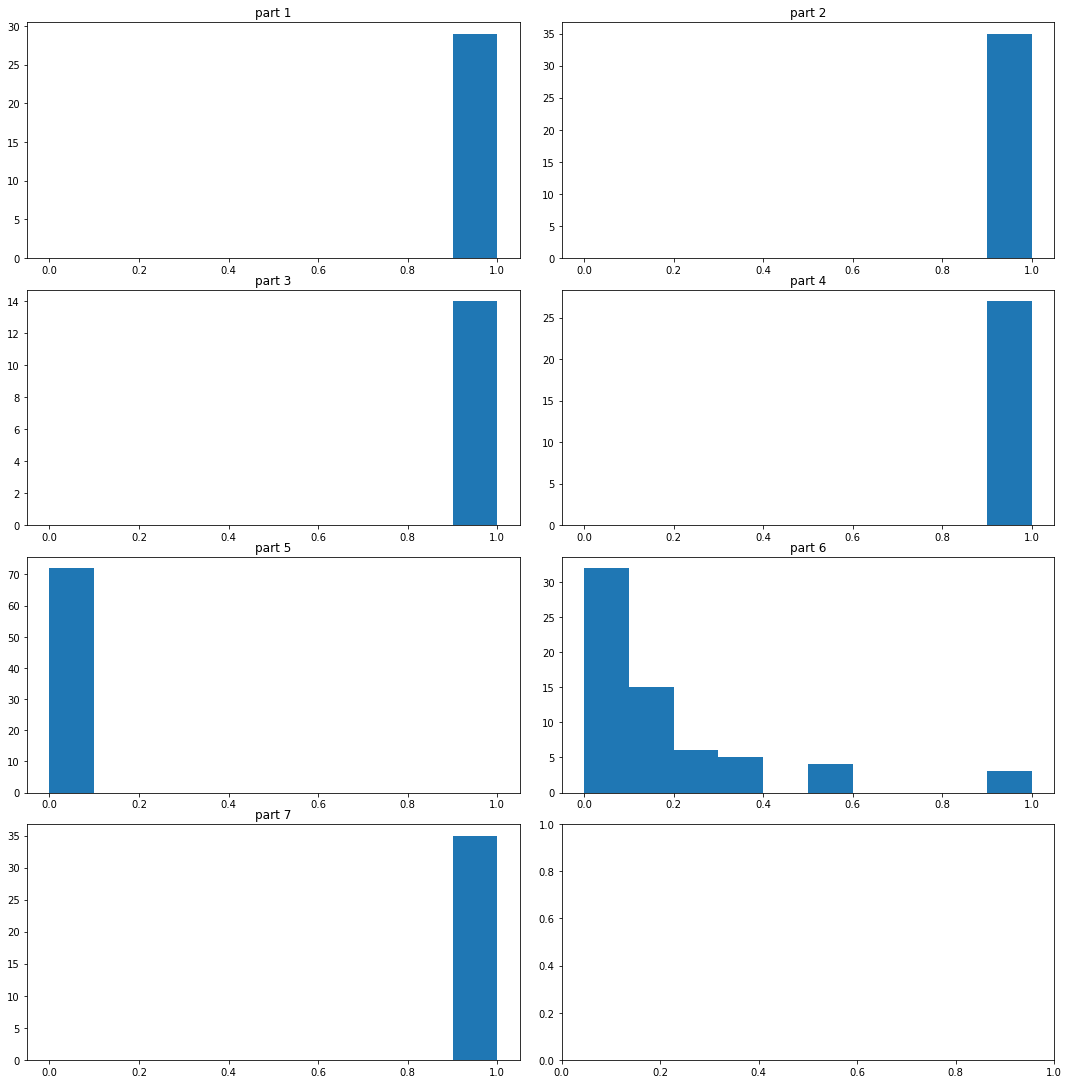

In [81]:
fig, axarr = plt.subplots(4, 2, figsize=(15, 15))
flat_axes_list = [item for sublist in axarr for item in sublist]

fig.tight_layout()

for part in range(1,8):
    # I want to specifically limit the logic to questions and tags in this part
    def calc_multitagged_in_part(tag_row):
        part_qs = questions[questions['part']==part]
        tag_qs = part_qs[part_qs['question_id'].isin(tag_row['questions'])]
        return tag_qs[tag_qs['multitag']==True].size/tag_qs.size
    part_multitagged = tags_df[tags_df['parts'].apply(lambda ps: part in ps)].apply(calc_multitagged_in_part, axis=1)
    ax = flat_axes_list[part-1]
    ax.set_title(f'part {part}')
    ax.hist(part_multitagged, bins=[x/10 for x in range(11)])

# combine lecture and question

In [82]:
tags_df['num_lectures'] = lectures.groupby('tag').count()['lecture_id']
tags_df['num_lectures'] = tags_df['num_lectures'].fillna(0).astype(int)

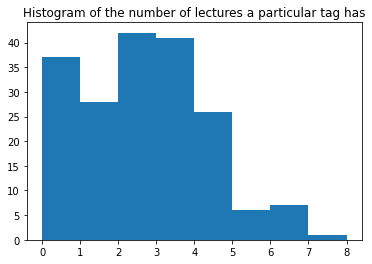

In [83]:
plt.hist(tags_df['num_lectures'], bins=range(9))
plt.title('Histogram of the number of lectures a particular tag has')
plt.show()

In [84]:
tags_df.head()

,tag,questions,fraction_multitagged,questions_no,parts,num_lectures
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,...",1.0,71,"(1,)",2
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.0,650,"(1,)",4
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)",1
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,...",1.0,2256,"(1, 2, 3, 4)",0
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975...",1.0,35,"(1,)",4


In [85]:
values = []
for i in tqdm(range(questions.shape[0])):
    if len(questions.iloc[i]["tags"]) > 0:
        values.append(sum([tags_df[tags_df.tag==j]["num_lectures"].values for j in questions.iloc[i]["tags"]])[0])
    else:
        values.append(0)

questions["num_of_lectures"] = values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [86]:
content_acc_mean = mod_train.groupby("content_id")["answered_correctly"].agg(["mean"])
questions = questions.merge(content_acc_mean, left_on="question_id", right_on="content_id", how="left")

In [87]:
questions[["mean", "num_of_lectures"]].corr()

,mean,num_of_lectures
mean,1.000000,0.146969
num_of_lectures,0.146969,1.000000


In [88]:
mod_train = pd.merge(mod_train, questions[["question_id", "bundle_id","part"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
mod_train.drop("question_id", axis=1, inplace=True) 

In [89]:
tmp = mod_train[mod_train.timestamp==0]["bundle_id"].value_counts(normalize=True).reset_index().copy()
tmp.columns = ["bundle_id", "ratio"]
minor_bundle = list(tmp.iloc[-2000:]["bundle_id"])
print(tmp.iloc[-2000:]["ratio"].sum())

0.08390586798608253


In [90]:
tmp

,bundle_id,ratio
0,7900,0.379947
1,128,0.035861
2,5692,0.008124
3,2063,0.001446
4,3363,0.001287
...,...,...
4511,664,0.000003
4512,408,0.000003
4513,1050,0.000003
4514,794,0.000003


In [91]:
start_bundle = mod_train[mod_train.timestamp==0]["bundle_id"].value_counts().reset_index()
start_bundle.columns = ["bundle_id", "count"]
start_bundle = start_bundle.merge(questions[["bundle_id", "part"]], how="left", on = "bundle_id")

In [92]:
start_bundle["part"].value_counts()

5    3165
2     802
6     359
1     274
7     257
3     192
4     189
Name: part, dtype: int64

In [93]:
start_bundle.head(50)

,bundle_id,count,part
0,7900,150587,1
1,128,14213,1
2,5692,3220,5
3,2063,573,3
4,2063,573,3
5,2063,573,3
6,3363,510,4
7,3363,510,4
8,3363,510,4
9,8154,335,7


In [94]:
start_bundle["count"].sum()

406319

In [95]:
mod_train[mod_train.bundle_id.isin(list(start_bundle.bundle_id.unique()))].shape[0]

63888675

In [96]:
start_bundle.shape

(5238, 3)

In [97]:
user_7900 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==7900)]["user_id"].unique()) # almost same
user_128 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==128)]["user_id"].unique()) # almost same
user_5692 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==5692)]["user_id"].unique()) # almost same
###################################################
user_2063 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==2063)]["user_id"].unique()) # not similar
user_3363 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==3363)]["user_id"].unique()) # not similar
user_5565 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==5565)]["user_id"].unique())
user_8154 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==8154)]["user_id"].unique())
user_4822 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==4822)]["user_id"].unique())
user_7216 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==7216)]["user_id"].unique())
user_6116 = list(mod_train[(mod_train.timestamp==0) & (mod_train.bundle_id==6116)]["user_id"].unique())

In [98]:
start_bundle[start_bundle.bundle_id==894]

,bundle_id,count,part
4542,894,2,2


In [99]:
for i in user_7900[:10]:
    print(i, mod_train[mod_train.user_id == i].head(35)["bundle_id"].drop_duplicates().values)

124 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6908 7216]
24418 [ 7900  7876   175  1278  2063  3363  2946  2593  4492  4120  4696  6116
  6173  6370  6908  7216   881   305  1274 10685   268]
24600 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6877 7216 4476 4981 6172 9887 5028]
32421 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6908 7216]
40828 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6877 7216 3733 4451 4433 5664 6193]
45001 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6877 7216]
53842 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6877 7216]
81429 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6877 7216]
91216 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6908 7216 5694 4456 5853 8896 6461]
107002 [7900 7876  175 1278 2063 3363 2946 2593 4492 4120 4696 6116 6173 6370
 6

In [100]:
for i in user_7216[:10]:
    print(i, mod_train[mod_train.user_id == i].head(35)["bundle_id"].drop_duplicates().values)

4580228 [7216 6601 5570 4147 3731 9788 4416 5674 6162 8776 4409 5696 3970 9062
 4419 6261 4458 7985 4988 5030 5258  148 7937 9825 6286 6143 4240 8528
 5340]
51015700 [ 7216  6908  6370  2946  7900  2593  4696  6173  4120  4492  1278  7876
   175  2063  6116  3363   893   313   360 10685   750]
176969395 [7216 4726 5363 4602 9006 6140 3698 6394 4038 5349 3717]
236331997 [7216 2946 4492 6908 6116 1278 3363 2063 6173  576 7900  294 7876  175
 4406 2593  980 6370 1387  551  420]
539909677 [ 7216  7884    37  7978 10485   139  5435  3878  4718  9640  5714  5034
  4556  9619  5158  5669  3871  9040  5585  3642  5188  8353  5657  4530
  6185  9021  3717  4407  4986  8544  4100  4667]
627896217 [ 7216   824  1163  1218 10686   817   526  1141 10687   802  1011]
657185293 [7216 6908 6370 6173 6116 4696 4120 4492 2593 2946 3363 2063 1278  175
 7876 7900  453]
907145868 [ 7216  3697  5177  6005  8832  5581  4529  5676  9037  5284  4995  5247
  9217  6072  6215  3878  9071  4426  4462  9259  9168 

In [101]:
for i in user_128[:10]:
    print(i, mod_train[mod_train.user_id == i].head(30)["bundle_id"].drop_duplicates().values, mod_train[mod_train.user_id == i].head(30)["timestamp"].max())

298022 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  100 7859] 20055038
983864 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  100 7859] 617457
993627 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  100 7859] 695322
1067196 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  100 7859] 847484
1084314 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  100 7859] 44454689
1359985 [ 128 7860 7922  156   51   50 7896 7863  152  104  108 7900 7901 7971
   25  183 7926 7927    4 7984   45  185   55 7876    6  172 7898  175
  10

In [102]:
for i in user_5692[:10]:
    print(i, mod_train[mod_train.user_id == i].head(10)["bundle_id"].drop_duplicates().values, mod_train[mod_train.user_id == i].head(30)["timestamp"].max())

115 [5692 5716  128 7860 7922  156   51   50 7896 7863] 692971
51285 [5692 4512 3566 5811 5132 4466 5183  888  288 1320] 871989
2078569 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 681173
2627685 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 634042
2727628 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 1004619
2800641 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 877889
3515794 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 528411
5294077 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 601865799
5373028 [5692 4237 3755 9604 4414 5674 4273 4216 9593 4725] 15236691192
5712442 [5692 5716 5344 6360 6410 6405 5392 5664 4789 5213] 2363612


In [103]:
for i in user_2063[:10]:
    print(i, mod_train[mod_train.user_id == i].head(10)["bundle_id"].drop_duplicates().values, mod_train[mod_train.user_id == i].head(30)["timestamp"].max())

8578103 [2063 3363 2946 2593] 704224
37296433 [2063 3363 2946 2593] 815712
47226491 [2063 3363 2946 2593] 24500614158
56184727 [2063 7900 7876  175 1278 7216] 10256381
57763481 [2063 3363 2946 2593] 975761
72266499 [2063 3363 2946 2593] 167524534
74024605 [2063  273 5300 6659 6117 5271 6435 5673] 176701737
100669189 [2063 3363 2946 2593] 7696026672
117172238 [2063 3363 2946 2593] 887283
117597543 [2063 3363 2946 2593] 1152323


In [104]:
mod_train[mod_train.user_id == 67704754].head(10)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part
3094180,0,67704754,5692,1,4294967295,False,5692,5
3094181,24727,67704754,4757,0,25000,False,4757,5
3094182,37110,67704754,3566,0,21000,False,3566,5
3094183,54269,67704754,5573,0,10000,False,5573,5
3094184,68355,67704754,4754,0,15000,False,4754,5
3094185,91548,67704754,6417,0,11000,False,6417,5
3094186,114929,67704754,205,0,20000,False,205,2
3094187,958419188,67704754,173,0,21000,False,173,1
3094188,958497710,67704754,7,1,23000,True,7,1
3094189,958561255,67704754,18,0,23000,True,18,1


In [105]:
mod_train[mod_train.user_id == 270866730].head(20)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part


In [106]:
mod_train[(mod_train.timestamp==0)]["part"].value_counts()

5    224805
1    165672
2      1963
4      1318
6       979
3       909
7       691
Name: part, dtype: int64

In [107]:
# tmp = mod_train[mod_train.timestamp==0]["bundle_id"].value_counts(normalize=True).reset_index().copy()
# tmp.columns = ["bundle_id", "ratio"]
# minor_bundle = list(tmp.iloc[-2000:]["bundle_id"])
# del tmp

# user_start_bundle_dict = mod_train[(mod_train.timestamp==0)][["user_id", "bundle_id"]].drop_duplicates().copy()
# user_start_bundle_dict = user_start_bundle_dict.set_index("user_id")
# user_start_bundle_count = user_start_bundle_dict["bundle_id"].value_counts().reset_index()
# user_start_bundle_count.columns = ["bundle_id", "count"]
# user_start_bundle_count = user_start_bundle_count.set_index("bundle_id")
# user_start_bundle_count = user_start_bundle_count.to_dict()
# user_start_bundle_dict = user_start_bundle_dict.to_dict()

# mod_train.iloc[:100]["user_id"].map(user_start_bundle_dict["bundle_id"]).map(user_start_bundle_count["count"])

In [108]:
#mod_train["user_id"].map(user_start_part_dict["part"]).values

In [109]:
mod_train[mod_train.timestamp==0].groupby("bundle_id")["answered_correctly"].mean()

bundle_id
0        1.000000
2        0.000000
3        0.500000
4        0.666667
5        1.000000
           ...   
12618    0.000000
13382    1.000000
13401    1.000000
13415    1.000000
13419    1.000000
Name: answered_correctly, Length: 4516, dtype: float64

# example_test
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [110]:
example_test.shape

(104, 11)

In [111]:
example_test.head(50)

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
5,5,0,18020362258,1364159702,12023,0,4424,18000.0,True,NaN,NaN
6,6,0,2325432079,1521618396,574,0,1367,18000.0,True,NaN,NaN
7,7,0,39456940781,1317245193,12043,0,5314,17000.0,True,NaN,NaN
8,8,0,3460555189,1700555100,7910,0,532,21000.0,True,NaN,NaN
9,9,0,2214770464,998511398,7908,0,393,21000.0,True,NaN,NaN


# how to make features

In [112]:
tmp = mod_train.iloc[:1000,:].copy()
tmp["prior_question_had_explanation"] = tmp["prior_question_had_explanation"].fillna(False).astype("int8")
#tmp = pd.merge(tmp, questions, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)

#del train

#tmp = pd.merge(tmp, questions[["question_id", "part", "community"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
#tmp.drop(columns=['question_id'], inplace=True)

# last 7 mean accuracy
#values = tmp.groupby("user_id")["answered_correctly"].shift().rolling(window=7).mean().values
#tmp["values"]=values
#values

In [113]:
#unique_attempt_array= train_df.groupby("user_id")["first_attempt"].cumsum().values
#train_df["unique_attempt"] = unique_attempt_array
#user_unique_agg = train_df.groupby('user_id')["unique_attempt"].agg(['max'])
#user_unique_dict = user_unique_agg['max'].astype('int32').to_dict(defaultdict(int))

In [114]:
#train_df["count_inday"] = 1
#count_inday_array = train_df.groupby(["user_id","timestamp"])["count_inday"].cumsum().values
#count_inday_array = count_inday_array[train_index]
#train_df.drop("count_inday", axis=1, inplace=True)

In [115]:
# daily accuracy
#tmp = mod_train.iloc[:500,:].copy()
#tmp['lag'] = tmp.groupby(["user_id","timestamp"])["answered_correctly"].shift()
#cum = tmp.groupby(["user_id","timestamp"])['lag'].agg(['cumsum', 'cumcount'])
#tmp["daily_accuracy"] = cum['cumsum'] / cum['cumcount']
#daily_accuracy_array = np.array(cum['cumsum'] / cum['cumcount'])
#daily_accuracy_array = daily_accuracy_array[train_index]
#tmp.drop(columns=['lag'], inplace=True)
#del cum
#tmp

In [116]:
# https://stackoverflow.com/questions/34027288/cumulative-counts-in-numpy-without-iteration

def rcount(a):
    without_reset = (a == 1).cumsum()
    reset_at = (a == 0)
    overcount = np.maximum.accumulate(without_reset * reset_at)
    result = without_reset - overcount
    return result

#tmp = train[train.user_id==5382].copy()
#change_index = list(tmp[tmp.content_type_id==1].index)
#tmp["new_feat"] = tmp['content_type_id'].replace(to_replace=0, method='ffill')
#tmp.loc[change_index, "new_feat"] = 0
#tmp["new_feat2"] = rcount(tmp["new_feat"].values)

#change_index = list(train_df[train_df.content_type_id==1].index)
#train_df["content_type_id"] = train_df.groupby("user_id")["content_type_id"].apply(lambda x: x.replace(to_replace=0, method='ffill'))
#train_df.loc[change_index, "content_type_id"] = 0
#train_df["content_type_id"] = train_df.groupby("user_id")["content_type_id"].apply(lambda x: rcount(x.values))

In [117]:
#print(1)
#train_df["part_count"] = train_df["lec_part"] ==1
#train_df["part_count"] = train_df["part_count"].astype("int8")
#train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
#lec_part1_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
#lec_part1_count_array = part1_count_array[train_index] 
#train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

In [118]:
#mod_train = pd.merge(mod_train, questions[["question_id", "part", "tags"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
#mod_train.drop("question_id", axis=1, inplace=True) 

In [119]:
#tag_num = 92
#par_tag_array = train_df["tags"].apply(lambda x: 1 if tag_num in x else 0).values
#train_df["tag_count"] = par_tag_array ==1
#train_df["tag_count"] = train_df["tag_count"].astype("int8")
#train_df['tag_count_lag'] = train_df.groupby('user_id')["tag_count"].shift()
#tag_count_array = train_df.groupby('user_id')['tag_count_lag'].agg(['cumsum']).values
#tag_count_array = tag_count_array[train_index] 
#train_df.drop(columns=['tag_count_lag', 'tag_count'], inplace=True)

#train_df["tag_correct_count"] = (par_tag_array ==1) & (train_df["answered_correctly"] == 1)
#train_df["tag_correct_count"] = train_df["tag_correct_count"].astype("int8")
#train_df['tag_correct_count_lag'] = train_df.groupby('user_id')["tag_correct_count"].shift()
#tag_correct_count_array = train_df.groupby('user_id')['tag_correct_count_lag'].agg(['cumsum']).values
#tag_correct_count_array = tag_correct_count_array[train_index] 
#train_df.drop(columns=['tag_correct_count_lag', 'tag_correct_count'], inplace=True)

In [120]:
# although tag information per user can be obtained, it builds features based on all activities.

#def join(df):
#    x = [str(e) for e in list(df)]
#    return " ".join(x)

#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import TruncatedSVD

#ids = ["tags"]
#concatenated_ = train[ids + ["user_id"]].copy().reset_index(drop=True)

#for id_ in ids:
#    print(id_)
#    docs = concatenated_.groupby("user_id")[id_].apply(join)
#    max_features = int(concatenated_[id_].nunique() * 0.8)
#    tv = TfidfVectorizer(max_features=max_features)
#    X = tv.fit_transform(docs)

#    n_components = 5
#    svd = TruncatedSVD(n_components=n_components)
#    X = svd.fit_transform(X)
#    df = pd.DataFrame(X, columns=[f"tfidf_{id_}_{i}" for i in range(n_components)])
#    df.index = docs.index

In [121]:
#train_users = list(train.user_id.unique())
#user_check = np.isin(example_test.user_id.values, train_users)
#example_test[user_check]

#user_check = np.isin(example_test.user_id.values, train_users)
#preds = np.zeros(len(example_test)) 
#pred_existing_users = model.predict(example_test.loc[user_check,features])
#pred_new_users = model2.predict(example_test.loc[~user_check,features])
#preds[user_check] = pred_existing_users
#preds[~user_check] = pred_new_users 

In [122]:
# how to make first_attempt
# takes about 10 minutes
#train["first_attempt"] = train[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                                                                    pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values

#for i in list(train.user_id.unique())[:10]:
#    tmp1 = np.isin(train[train.user_id==i]["row_id"].values, train[train.user_id==i].groupby("content_id").first()["row_id"].values)
#    tmp2 = np.isin(train[train.user_id==i]["row_id"], train[train.user_id==i].drop_duplicates("content_id")["row_id"])
#    print(i, np.all(tmp1 == tmp2))

#train[["row_id", "first_attempt"]].to_csv("content_first_attempt.csv", index=False)

In [123]:
#mod_train = train.iloc[:100,:].copy()
#mod_train["first_attempt"] = mod_train[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                                                                    pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values
#mod_train.head()

In [124]:
#%%time
#user_content_agg = train.groupby("user_id")["content_id"].unique().reset_index().set_index("user_id")

#value = []
#for j in user_content_agg.index:
#    a = bitarray(32737, endian='little')
#    a.setall(True)
#    for i in user_content_agg.loc[j][0]:
#        a[i] = 0
#    value.append(a)
    
#user_content_agg["content_exp"] = value

#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(int))

In [125]:
#user_content_dict = user_content_agg["content_exp"].to_dict()
#mod_first_attempt_values = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    if not user_id in user_content_dict.keys():
#        a = bitarray(32737, endian='little')
#        a.setall(True)   
#        user_content_dict[user_id] = a
#    mod_first_attempt_values.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [126]:
#def make_bitarray():
#    a = bitarray(32737, endian='little')
#    a.setall(True)   
#    return a
    
#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(make_bitarray))
#mod_first_attempt_values2 = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    mod_first_attempt_values2.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [127]:
#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(int))
#first_attempt_values = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    if not user_id in user_content_agg.index:
#        a = bitarray(32737, endian='little')
#        a.setall(True)   
#        user_content_dict[user_id] = a
#    first_attempt_values.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [128]:
#from bitarray import bitarray
#sample_list = []
#for i in range(393656):
#    a = bitarray(13782, endian='little') # important to setup a fixed endianess.
#    a.setall(True)
#    sample_list.append(a)

In [129]:
#user_agg = train.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
#user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
#user_count_dict

In [130]:
#user_try = train.groupby('user_id')['row_id'].agg(["count"])
#user_try_dict = user_try['count'].astype('int16').to_dict(defaultdict(int))
#user_try_dict.head()

In [131]:
#user_count_dict == user_try_dict

In [132]:
#train_df["part_correct_count"] = (train_df["part"] == 1) & (train_df["answered_correctly"]==1)
#train_df["part_correct_count"] = train_df["part_correct_count"].astype("int8")
#train_df['part_correct_count_lag'] = train_df.groupby('user_id')["part_correct_count"].shift()
#part1_correct_count_array = train_df.groupby('user_id')['part_correct_count_lag'].agg(['cumsum']).values
#part1_correct_count_array = part1_correct_count_array[train_index]
#part1_accuracy_array = part1_correct_count_array / part1_count_array 
#train_df.drop(columns=['part_correct_count_lag', 'part_correct_count'], inplace=True)

# https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes/23435843
#tmp_part_array = np.hstack((part1_count_array, part2_count_array, part3_count_array, part4_count_array, part5_count_array, part6_count_array, part7_count_array))
#this_part_count_array = tmp_part_array[np.arange(len(tmp_part_array)), train_df.part.values[train_index]-1]
#del tmp_part_array

#tmp_part_array = np.hstack((part1_correct_count_array, part2_correct_count_array,
#                            part3_correct_count_array, part4_correct_count_array, 
#                            part5_correct_count_array, part6_correct_count_array, part7_correct_count_array))
#this_part_correct_count_array = tmp_part_array[np.arange(len(tmp_part_array)), train_df.part.values[train_index]-1]
#del tmp_part_array

#tmp_part_array = np.hstack((part1_accuracy_array, part2_accuracy_array,
#                            part3_accuracy_array, part4_accuracy_array, 
#                            part5_accuracy_array, part6_accuracy_array, part7_accuracy_array))
#this_part_accuracy_array = tmp_part_array[np.arange(len(tmp_part_array)), train_df.part.values[train_index]-1]
#del tmp_part_array

In [133]:
def rcount(a):
    without_reset = (a == True).cumsum()
    reset_at = (a == False)
    overcount = np.maximum.accumulate(without_reset * reset_at)
    result = without_reset - overcount
    return result

def rcount_test(a):
    without_reset = (a == 1).cumsum()
    reset_at = (a == 0)
    overcount = np.maximum.accumulate(without_reset * reset_at)
    result = without_reset - overcount
    return result

#lectures = pd.read_csv("../input/riiid-test-answer-prediction/lectures.csv")

#lecture_count_dict = train_df[train_df["answered_correctly"] == -1]["content_id"].value_counts().reset_index(drop=False)
#lecture_count_dict.columns = ["content_id", "lecture_count"]
#lecture_count_dict = lecture_count_dict.set_index("content_id")
#remain_lecture = list(set(lectures.lecture_id) -set(lecture_count_dict.index))
#lecture_count_dict = lecture_count_dict.to_dict()
#for i in remain_lecture:
#    lecture_count_dict[i] = 0

#lectures = lectures.astype({"lecture_id": 'int16', 'part': 'int8'})
#train_df = train_df.merge(lectures[['lecture_id']], left_on="content_id", right_on="lecture_id", how="left") #, 'part'
#last_lecture_array = train_df.groupby("user_id")["lecture_id"].shift().values
#train_df.drop(["lecture_id"], axis=1, inplace=True)
#last_lecture_part_array = train_df.groupby("user_id")["part"].shift().values
#train_df.drop(["part"], axis=1, inplace=True)

#change_index = list(train_df[train_df.content_type_id==1].index)
#train_df["content_type_id"] = train_df.groupby("user_id")["content_type_id"].progress_apply(lambda x: x.replace(to_replace=False, method='ffill'))
#train_df.loc[change_index, "content_type_id"] = False
#count_from_lec_array = train_df.groupby("user_id")["content_type_id"].progress_apply(lambda x: rcount(x.values)).values
#count_from_lec_array = np.hstack(count_from_lec_array)

#mask = np.ones(count_from_lec_array.shape,dtype=bool)
#mask[change_index] = False
#count_from_lec_array = count_from_lec_array[mask]
#last_lecture_array = last_lecture_array[mask]
#del mask, change_index

#count_from_lec_array = count_from_lec_array[train_index]

#train_df["last_lecture"] = last_lecture_array
#last_lecture_array = train_df.groupby("user_id")["last_lecture"].ffill().values
#train_df.drop(["last_lecture"], axis=1, inplace=True)
#train_df["last_lecture_part"] = last_lecture_part_array
#last_lecture_part_array = train_df.groupby("user_id")["last_lecture_part"].ffill().values
#train_df.drop(["last_lecture_part"], axis=1, inplace=True)
#last_lecture_array = last_lecture_array[train_index]
#last_lecture_part_array = last_lecture_part_array[train_index]

#train_df['last_lecture'] = last_lecture_array
#user_count_from_lec_dict = train_df.groupby("user_id").tail(1)['count_from_lec'].to_dict(defaultdict(int))
#user_last_lecture_dict = train_df.groupby("user_id").tail(1)["last_lecture"].to_dict(defaultdict(int))

In [134]:
#%%time
#user_id_list = train_df.user_id.tolist()
#tags_list = train_df.tags.tolist()
#target_list = train_df[target].tolist()
#try_list = []
#correct_list = []
#for user_id, tags, target_ in tqdm(zip(user_id_list, tags_list, target_list), total=len(user_id_list)):
#    for i in tags:
#        user_tag_try[user_id][i] += 1
#    if target_ == 1:
#        for i in tags:
#            user_tag_correct[user_id][i] += 1
#    try_list.append(user_tag_try[user_id])
#    correct_list.append(user_tag_correct[user_id])
#del user_id_list, tags_list, target_list

#train_df["tag_try"] = try_list
#del try_list
#tag_try_array = train_df.groupby("user_id")["tag_try"].shift().values
#tag_try_array = tag_try_array[train_index]
#train_df.drop(["tag_try"], axis=1, inplace=True)

#train_df["tag_correct"] = correct_list
#del correct_list
#tag_correct_array = train_df.groupby("user_id")["tag_correct"].shift().values
#tag_correct_array = tag_correct_array[train_index]
#train_df.drop(["tag_correct"], axis=1, inplace=True)

In [135]:
# #https://stackoverflow.com/questions/33294489/pandas-exponentially-decaying-sum-with-variable-weights

# @jit(nopython=True)
# def exponential_sum(A, k):
#     total = A[0]
#     yield total
#     for i in range(1, len(A)):  # Use range in Python 3.
#         total = total * k[i] + A[i]
#         yield total

# df = pd.DataFrame({'time': [1, 1, 1, 2, 10, 10], 
#                    'A': [1, 3, 1, 7, 2, 1]})

# # Initial decay parameter.
# decay_constant = 0.5
# df['weight'] = decay_constant ** df.time.diff() 
# df.weight.iat[0] = 1
# df["decayed_count"] = np.array(list(exponential_sum(df.A.values, df.weight.values)))
# df

In [136]:
# @jit(nopython=True)
# #def exponential_sum(A, k):
# #    total = A[0]
# #    yield total
# #    for i in range(1, len(A)):  # Use range in Python 3.
# #        total = total * k[i] + A[i]
# #        yield total

# #decay_constant = 0.5

# #mod_train["weight"] = mod_train.groupby("user_id")["timestamp"].diff()
# #mod_train["weight"].fillna(0, inplace=True)
# #mod_train["weight"] = decay_constant ** mod_train["weight"]
# #mod_train["count"] = 1

In [137]:
# @jit(nopython=True)
# def exponential_sum(A, k):
#     total = A[0]
#     yield total
#     for i in range(1, len(A)):  # Use range in Python 3.
#         total = total * k[i] + A[i]
#         yield total

In [138]:
# @jit
# def mod_exponential_sum(A):
#     ans = [A[0]]
#     for i in range(1, len(A)):  # Use range in Python 3.
#         total = ans[-1] * 0.1 + A[i]
#         ans.append(total)
#     return np.array(ans)

In [139]:
#%%time
#tmp_values2 = mod_train.groupby("user_id").apply(lambda x: mod_exponential_sum(x["count"].values, x.weight.values))
#tmp_values2 = np.hstack(tmp_values2)
#tmp["values"]= tmp_values2

In [140]:
#%%time
#tmp_values = tmp.groupby("user_id").apply(lambda x: list(exponential_sum(x["count"].values, x.weight.values)))
#tmp_values = np.hstack(tmp_values)

In [141]:
#tmp["count"] = 1
#tmp["count"] = tmp.groupby(["user_id", "timestamp"])["count"].cumsum()
#tmp_values = tmp.groupby("user_id").apply(lambda x: x["count"].shift().values * x["weight"].values +1).values
#tmp_values = np.hstack(tmp_values)
#tmp["decayed_count"] = tmp_values

In [142]:
#@jit
#def mod_exponential_sum(A, k):
#    ans = [A[0]]
#    for i in range(1, len(A)):  # Use range in Python 3.
#        total = ans[-1] * k[i] + A[i]
#        ans.append(total)
#    return np.array(ans)

# decayed cumsum
#decay_constant = 0.5
#weight_array = train_df.groupby("user_id")["timestamp"].diff().fillna(0).values
#train_df["weight"] = decay_constant ** weight_array
#del weight_array
#decayed_count_array = train_df.groupby("user_id").progress_apply(lambda x: mod_exponential_sum(x["count"].values, x.weight.values))
#train_df.drop("weight", axis=1, inplace=True)
#decayed_count_array = np.hstack(decayed_count_array)
#decayed_count_array = decayed_count_array[train_index]

In [143]:
# no_check_array = tmp.groupby("user_id").apply(lambda x: x["answered_correctly"].shift().values == x["prior_question_had_explanation"].values)
# no_check_array = np.hstack(no_check_array).astype('int8')
# tmp["no_check"] = no_check_array

In [144]:
# @jit
# def kakin(D, C):
#     ans = []
#     flg = 0
#     for i in range(len(C)):
#         if flg == 0:
#             if D[i] == 1 and C[i] > 30:
#                 flg = 1
#             elif D[i] >= 2 and C[i] > 20:
#                 flg = 1
#         ans.append(flg)
#     return np.array(ans)

# #tmp["count"] = 1
# #count_array = tmp.groupby(["user_id"])["count"].cumsum().values
# #tmp["count"] = count_array

# #tmp["count_inday"] = 1
# #count_inday_array = tmp.groupby(["user_id","day_timestamp"])["count_inday"].cumsum().values
# #tmp["count_inday"] = count_inday_array

# kakin_array = tmp.groupby("user_id").apply(lambda x: kakin(x["day_timestamp"].values, x["count_inday"].values)).values
# kakin_array = np.hstack(kakin_array)
# #tmp["kakin"] = kakin_array

In [145]:
# @jit
# def tag_accuracy(A, C):
#     ans = []
#     community_count = [0] * 42
#     community_correct = [0] * 42
#     for i in range(len(C)):
#         if community_count[C[i]]==0:
#             ans.append(-1)
#         else:
#             ans.append(community_correct[C[i]]/community_count[C[i]])
#         community_count[C[i]] +=1
#         community_correct[C[i]] += A[i]
#     return np.array(ans)

# tag_acc_array = tmp.groupby("user_id").apply(lambda x: tag_accuracy(x["answered_correctly"].values, x["community"].values)).values
# tag_acc_array = np.hstack(tag_acc_array)
# tmp["tag_acc"] = tag_acc_array
# tmp

In [146]:
# @jit
# def tag_correct_last(A, C):
#     community_correct = [0] * 42
#     for i in range(len(C)):
#         community_correct[C[i]] += A[i]
#     return np.array(community_correct)

# @jit
# def tag_count_last(A, C):
#     community_count = [0] * 42
#     for i in range(len(C)):
#         community_count[C[i]] +=1
#     return np.array(community_count)

# def init_dict():
#     ans = [0] * 42
#     return np.array(ans)

In [147]:
# tmp_dict = tmp.groupby("user_id").apply(lambda x: tag_correct_last(x["answered_correctly"].values, x["community"].values)).to_dict(defaultdict(init_dict))

In [148]:
# %%time
# average_value1 = tmp.groupby("user_id")["answered_correctly"].shift().rolling(window=7).mean().values
# tmp["average1"] = average_value1

In [149]:
# @jit
# def accuracy_last7(A, U):
#     prev_user = ""
#     ans = []
    
#     for i in range(len(A)):
#         if prev_user != U[i]:
#             count = 0
#             prev_user = U[i]
            
#         if count < 7:
#             ans.append(np.nan)
#         else:
#             ans.append(np.mean(A[count-7:count])) 
#         count += 1
#     return np.array(ans)

In [150]:
# %%time
# average_value2 = accuracy_last7(tmp["user_id"].values, tmp["answered_correctly"].values)
# average_value2 = np.hstack(average_value2)
# tmp["average2"] = average_value2

In [151]:
#tmp_dict = tmp.groupby("user_id")["answered_correctly"].apply(lambda x: x[-7:].values).to_dict(defaultdict(partial(np.ndarray, 0, dtype="int8")))

In [152]:
#https://stackoverflow.com/questions/32828922/insert-elements-to-beginning-and-end-of-numpy-array
#tmp_dict[0] = np.concatenate([tmp_dict[0],[1]])

In [153]:
#tmp["had_explanation_in_correct"] = tmp.answered_correctly.values * tmp.prior_question_had_explanation.values

In [154]:
#tmp['lag'] = tmp.groupby('user_id')['had_explanation_in_correct'].shift()
#cum = tmp.groupby('user_id')['lag'].agg(['cumsum'])
#tmp.drop('lag', axis=1, inplace=True)
#tmp['lag'] = tmp.groupby('user_id')['answered_correctly'].shift()
#cum2 = tmp.groupby('user_id')['lag'].agg(['cumsum'])
#tmp.drop('lag', axis=1, inplace=True)
#tmp['had_explanation_in_correct_mean'] = np.array(cum['cumsum'] / cum2['cumsum'])
#tmp['time_to_correct_one'] = (tmp['timestamp'] / cum2['cumsum']).astype(int)
#del cum, cum2

In [155]:
@jit
def last_incorrect_time(A, K):
    ans = [-1]
    tmp_last = -1
    for i in range(1, len(A)): 
        if A[i-1] == 0:
            ans.append(K[i-1])
            tmp_last = K[i-1]
        else:
            ans.append(tmp_last)
    return np.array(ans) 

@jit
def last_correct_time(A, K):
    ans = [-1]
    tmp_last = -1
    for i in range(1, len(A)): 
        if A[i-1] == 1:
            ans.append(K[i-1])
            tmp_last = K[i-1]
        else:
            ans.append(tmp_last)
    return np.array(ans) 

#values  = tmp.groupby("user_id").apply(lambda x: last_incorrect_time(x["answered_correctly"].values, x["timestamp"].values))
#values = np.hstack(values).astype('int64')
#values2  = tmp.groupby("user_id").apply(lambda x: last_correct_time(x["answered_correctly"].values, x["timestamp"].values))
#values2 = np.hstack(values2).astype('int64')
#tmp["values"] = values
#tmp["values2"] = values2

#tmp

In [156]:
# @jit
# def last_part_time(P, T):
#     flg = [-1,-1,-1,-1,-1,-1,-1,-1]
#     ans = [-1]
#     for i in range(1, len(P)): 
#         flg[P[i-1]] = T[i-1]
#         ans.append(flg[P[i]])
#     return np.array(ans) 

# last_part_time_array = tmp.groupby("user_id").apply(lambda x: last_part_time(x["part"].values, x["timestamp"].values))
# last_part_time_array = np.hstack(last_part_time_array).astype('int64')
    
# nan_index = np.where(last_part_time_array == -1)

# last_part_timediff_array = tmp.timestamp.values - last_part_time_array
# last_part_timediff_array[nan_index] = -1
# tmp["values"] = last_part_timediff_array.astype('int64')
# tmp

In [157]:
# @jit
# def last_part_time(P, T):
#     flg = [-1,-1,-1,-1,-1,-1,-1,-1]
#     ans = [-1]
#     for i in range(1, len(P)): 
#         flg[P[i-1]] = T[i-1]
#         ans.append(flg[P[i]])
#     return np.array(ans) 

# last_part_time_array = tmp.groupby("user_id").apply(lambda x: last_part_time(x["part"].values, x["timestamp"].values)).values
# last_part_time_array = np.hstack(last_part_time_array).astype('int64')
# tmp["values"] = last_part_time_array

# tmp

In [158]:
#@jit
#def target2dec(A):
#    ans = [A[0]]
#    for i in range(1, len(A)): 
#        total = ans[-1] * 0.1 + A[i]
#        ans.append(total)
#    return np.array(ans)

# target2dec
#target_dec_array = train_df.groupby("user_id").apply(lambda x: target2dec(x["answered_correctly"].values))
#target_dec_array = np.hstack(target_dec_array)
#train_df["target_dec"] = target_dec_array
#target_dec_dict = train_df.groupby("user_id").tail(1)["target_dec"].to_dict()
#target_dec_array = train_df.groupby("user_id")["target_dec"].shift().values
#target_dec_array = target_dec_array[train_index]
#train_df.drop("target_dec", axis=1, inplace=True)

# part2dec
#part_dec_array = train_df.groupby("user_id").apply(lambda x: target2dec(x["part"].values))
#part_dec_array = np.hstack(part_dec_array)
#train_df["part_dec"] = part_dec_array
#part_dec_dict = train_df.groupby("user_id").tail(1)["part_dec"].to_dict()
#part_dec_array = train_df.groupby("user_id")["part_dec"].shift().values
#part_dec_array = part_dec_array[train_index]
#train_df.drop("part_dec", axis=1, inplace=True)

In [159]:
@jit
def acquisition_skill(A, C):
    ans = []
    community_count = [0] * community_num
    community_correct = [0] * community_num
    for i in range(len(C)):
        accuracy = np.array(community_correct) / np.array(community_count)
        ans.append(np.sum((accuracy > 0.7) & (np.array(community_count) > 5)))
        community_count[C[i]] +=1
        community_correct[C[i]] += A[i]
    return np.array(ans)

#skill_array = train_df.groupby("user_id").apply(lambda x: acquisition_skill(x["answered_correctly"].values, x["community"].values))
#skill_array = np.hstack(skill_array)
#skill_array = skill_array[train_index]

In [160]:
#no_check_array = train_df.groupby("user_id").apply(lambda x: x["answered_correctly"].shift().values == x["prior_question_had_explanation"].values)
#no_check_array = np.hstack(no_check_array).astype('int8')
#train_df["no_check"] = no_check_array
#no_check_array = train_df.groupby("user_id")["no_check"].cumsum().values
#no_check_array = no_check_array[train_index]
#train_df.drop("no_check", axis=1, inplace=True)

In [161]:
# @jit
# def time_from_same_comm_lec_calc(A, C, T):
#     ans = []
#     question_community_time = [-1] * community_num
#     lecture_community_time = [-1] * community_num
#     for i in range(len(C)):
#         if A[i] == -1:
#             lecture_community_time[C[i]] = T[i]
#             ans.append(0)
#         else:
#             question_community_time[C[i]] = T[i]
#             if lecture_community_time[C[i]] == -1:
#                 ans.append(-1)
#             else:
#                 ans.append(question_community_time[C[i]] - lecture_community_time[C[i]])
#     return np.array(ans)

# tmp = train.iloc[:10000,:].copy()
# time_from_same_comm_lec_array = tmp.groupby("user_id").apply(lambda x: time_from_same_comm_lec_calc(x["answered_correctly"].values, 
#                                                                                   x["ql_community"].values,
#                                                                                   x["timestamp"].values,))
# time_from_same_comm_lec_array = np.hstack(time_from_same_comm_lec_array)
# tmp["values"] = time_from_same_comm_lec_array 

In [162]:
# #memory over...
# @jit
# def last_lec_from_same_comm_calc(A, C, CON):
#     ans = []
#     lecture_id = [-1] * community_num
#     for i in range(len(C)):
#         if A[i] == -1:
#             lecture_id[C[i]] = CON[i]
#             ans.append(0)
#         else:
#             ans.append(lecture_id[C[i]])
#     return np.array(ans)

# #tmp = train.iloc[:1000,:].copy()
# last_lec_from_same_comm_array = tmp.groupby("user_id").apply(lambda x: last_lec_from_same_comm_calc(x["answered_correctly"].values, 
#                                                                                   x["ql_community"].values,
#                                                                                   x["content_id"].values,))
# last_lec_from_same_comm_array = np.hstack(last_lec_from_same_comm_array)
# tmp["values2"] = last_lec_from_same_comm_array 

In [163]:
# @jit
# def part_count_calc(P):
#     ans = []
#     part_count = [0] * 8
#     for i in range(len(P)):
#         part_count[P[i]] += 1
#         ans.append(part_count[P[i]])
#     return np.array(ans)

# @jit
# def part_count_dict_calc(P):
#     part_count = [0] * 8
#     for i in range(len(P)):
#         part_count[P[i]] += 1
#     return np.array(part_count)

# def part_dict_init():
#     ans = [0] * 8
#     return np.array(ans)

# tmp = mod_train.iloc[:1000,:].copy()
# part_count_calc_array = tmp.groupby("user_id").apply(lambda x: part_count_calc(x["part"].values))
# part_count_calc_array = np.hstack(part_count_calc_array)

# user_part_count_dict = tmp.groupby("user_id").apply(lambda x: part_count_dict_calc(x["part"].values)).to_dict(defaultdict(part_dict_init))

# tmp["part_count_calc"] = part_count_calc_array 

In [164]:
tmp = mod_train.iloc[:10000,:].copy()

from collections import defaultdict

ALPHA = 0.8

u_last_n_stats = defaultdict(lambda: LastNStats(n=20))
u_moving_acc = {}
ans = []

for i, row in tmp.iterrows():
    u = row["user_id"]
    ans_res = row["answered_correctly"]
    last_20_acc = u_last_n_stats[u].get_mean()
    # add last_20_acc to feature dataframe

    mov_acc = u_moving_acc.get(u)
    # add mov_acc to feature dataframe

    # Update
    u_last_n_stats[u].append(ans_res)
    if mov_acc is not None:
        mov_acc = (1 - ALPHA) * mov_acc + ALPHA * u_last_n_stats[u].get_mean()
    else:
        mov_acc = last_20_acc
    ans.append(mov_acc)
    #u_moving_acc[u] = mov_acc

NameError: name 'LastNStats' is not defined

In [165]:
target = 'answered_correctly'
content_agg = mod_train.groupby('content_id')[target].agg(['sum', 'count'])
#content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
#content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))
#content_count_array = mod_train['content_id'].map(content_agg['count']).astype('int32').values
content_id_array = mod_train['content_id'].map(content_agg['sum'] / content_agg['count']).values
del content_agg
mod_train['content_id'] = content_id_array
del content_id_array

In [166]:
point_array = 1 / (mod_train['content_id'].values + 0.1)
mod_train["got_point"] = point_array * mod_train["answered_correctly"].values

In [167]:
# @jit
# def last7(A):
#     ans = []
#     for i in range(len(A)):
#         if i < 7:
#             ans.append(np.nan)
#         else:
#             ans.append(np.mean(A[i-7:i]))       
#     return np.array(ans)

# @jit
# def last_max(A):
#     ans = []
#     maxi = 0.0
#     for i in range(len(A)):
#         ans.append(maxi)
#         if A[i] > maxi:
#             maxi = A[i]
#     return np.array(ans)

# @jit
# def mod_exponential_sum(A):
#     ans = [A[0]]
#     for i in range(1, len(A)):  # Use range in Python 3.
#         total = ans[-1] * 0.8 + A[i]
#         ans.append(total)
#     return np.array(ans)

# tmp = mod_train.iloc[:10000,:].copy()
# tmp["count"] = 1
# got_point_last7_array = tmp.groupby("user_id").apply(lambda x: last7(x['got_point'].values))
# got_point_last7_array = np.hstack(got_point_last7_array)
# tmp["got_point_last7"] = got_point_last7_array

# got_point_max_array = tmp.groupby("user_id").apply(lambda x: mod_exponential_sum(x['got_point'].values))
# got_point_max_array = np.hstack(got_point_max_array)
# tmp["decay_sum"] = got_point_max_array

# decay_count_array = tmp.groupby("user_id").apply(lambda x: mod_exponential_sum(x['count'].values))
# decay_count_array = np.hstack(decay_count_array)
# tmp["decay_count"] = decay_count_array

In [168]:
# import math 

# @jit
# def target2dec(A):
#     ans = [A[0]]
#     for i in range(1, len(A)): 
#         n = 0  # 切り捨てしたい桁
#         y = math.floor(ans[-1] * (10 ** n)) / (10 ** n)
#         total = y * 0.1 + A[i]
#         ans.append(total)
#     return np.array(ans)

# # target2dec
# target_dec_array = tmp.groupby("user_id").apply(lambda x: target2dec(x["answered_correctly"].values))
# target_dec_array = np.hstack(target_dec_array)
# tmp["target_dec"] = target_dec_array
# target_dec_dict = tmp.groupby("user_id").tail(1)["target_dec"].to_dict(defaultdict(lambda : -1.0))
# target_dec_array = tmp.groupby("user_id")["target_dec"].shift().values
# tmp["target_dec"] = target_dec_array
# #target_dec_array = target_dec_array[train_index]
# #train_df.drop("target_dec", axis=1, inplace=True)

In [169]:
@jit
def continuous_correct(A):
    ans = []
    count = 0
    for i in range(len(A)): 
        ans.append(count)
        if A[i] ==1:
            count += 1
        else:
            count = 0
    return np.array(ans)
continuous_correct_array = tmp.groupby("user_id").apply(lambda x: continuous_correct(x["answered_correctly"].values))
continuous_correct_array = np.hstack(continuous_correct_array)
tmp["values"] = continuous_correct_array

@jit
def continuous_incorrect(A):
    ans = []
    count = 0
    for i in range(len(A)): 
        ans.append(count)
        if A[i] ==0:
            count += 1
        else:
            count = 0
    return np.array(ans)
continuous_incorrect_array = tmp.groupby("user_id").apply(lambda x: continuous_incorrect(x["answered_correctly"].values))
continuous_incorrect_array = np.hstack(continuous_incorrect_array)
tmp["values2"] = continuous_incorrect_array

@jit
def continuous_correct_dict_calc(A):
    count = 0
    for i in range(len(A)): 
        if A[i] ==1:
            count += 1
        else:
            count = 0
    return count

@jit
def continuous_incorrect_dict_calc(A):
    count = 0
    for i in range(len(A)): 
        if A[i] ==0:
            count += 1
        else:
            count = 0
    return count

continuous_incorrect_dict = tmp.groupby("user_id").apply(lambda x: continuous_incorrect_dict_calc(x["answered_correctly"].values)).to_dict(defaultdict(int))
continuous_correct_dict = tmp.groupby("user_id").apply(lambda x: continuous_correct_dict_calc(x["answered_correctly"].values)).to_dict(defaultdict(int))

In [170]:
@jit
def timediff_in_correct(A):
    ans = []
    count = 0
    for i in range(len(A)): 
        ans.append(count)
        if A[i] ==0:
            count += 1
        else:
            count = 0
    return ans

accuracy_pct_change_array = tmp.groupby("user_id").apply(lambda x: pct_change(x["values"].values))
accuracy_pct_change_array = np.hstack(accuracy_pct_change_array)
#accuracy_pct_change_array = accuracy_pct_change_array[train_index]
tmp["values2"] = accuracy_pct_change_array

time_pct_change_array = tmp.groupby("user_id").apply(lambda x: pct_change(x["timestamp"].values))
time_pct_change_array = np.hstack(time_pct_change_array)
#accuracy_pct_change_array = accuracy_pct_change_array[train_index]
tmp["time_pct_change"] = time_pct_change_array

NameError: name 'pct_change' is not defined

In [171]:
@jit
def count_incorrect_calc(A):
    ans = []
    count = 0
    for i in range(len(A)): 
        ans.append(count)
        if A[i] ==0:
            count += 1
    return ans

time_pct_change_array = tmp.groupby("user_id").apply(lambda x: count_incorrect_calc(x["answered_correctly"].values))
time_pct_change_array = np.hstack(time_pct_change_array)
tmp["incorrect"] = time_pct_change_array
tmp.head(100)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,values,values2,incorrect
0,0,115,5692,1,4294967295,False,5692,5,0,0,0
1,56943,115,5716,1,37000,False,5716,5,1,0,0
2,118363,115,128,1,55000,False,128,1,2,0,0
3,131167,115,7860,1,19000,False,7860,1,3,0,0
4,137965,115,7922,1,11000,False,7922,1,4,0,0
5,157063,115,156,1,5000,False,156,1,5,0,0
6,176092,115,51,1,17000,False,51,1,6,0,0
7,194190,115,50,1,17000,False,50,1,7,0,0
8,212463,115,7896,1,16000,False,7896,1,8,0,0
9,230983,115,7863,1,16000,False,7863,1,9,0,0


In [172]:
bundle_id_df = questions.bundle_id.value_counts().reset_index()
bundle_id_df.columns = ["bundle_id", "count"]
bundle_id_df.set_index("bundle_id")

simultaneous_no = tmp["bundle_id"].map(bundle_id_df["count"]).values

In [173]:
bundle_id_df = questions.bundle_id.value_counts().reset_index()
bundle_id_df.columns = ["bundle_id", "count"]
multi = list(bundle_id_df[bundle_id_df["count"]>1]["bundle_id"])
not_multi = list(bundle_id_df[bundle_id_df["count"]==1]["bundle_id"])

mod_train[mod_train.bundle_id.isin(multi)]["answered_correctly"].mean(), mod_train[mod_train.bundle_id.isin(not_multi)]["answered_correctly"].mean()

(0.6668648002255358, 0.652620070703528)

In [174]:
@jit
def count_incorrect_calc(A):
    ans = []
    count = 0
    for i in range(len(A)): 
        ans.append(count)
        if A[i] ==0:
            count += 1
    return ans

count_incorrect_array = train_df.groupby("user_id").apply(lambda x: count_incorrect_calc(x["answered_correctly"].values))
count_incorrect_array = np.hstack(count_incorrect_array)
count_incorrect_array = count_incorrect_array[train_index] 

NameError: name 'train_df' is not defined

In [175]:
# past 1800000(過去10分のトライ数)
# @jit
# def past_time_count(T):
#     ans = []
#     for i in range(len(T)): 
#         past_limit = T[i] - 600000
#         ans.append(np.sum((T < T[i]) & (T >= past_limit)))
#     return ans

# @jit
# def past_time_acc(A, T):
#     ans = []
#     for i in range(len(T)): 
#         past_limit = T[i] - 600000
#         ind = (T < T[i]) & (T >= past_limit)
#         ans.append(np.sum(A[ind]))
#     return ans

# past_time_count_array = tmp.groupby("user_id").apply(lambda x: past_time_count(x["timestamp"].values))
# past_time_count_array = np.hstack(past_time_count_array)
# past_time_acc_array = tmp.groupby("user_id").apply(lambda x: past_time_acc(x["answered_correctly"].values,x["timestamp"].values))
# past_time_acc_array = np.hstack(past_time_acc_array)
# tmp["values"] = past_time_count_array
# tmp["values2"] = past_time_acc_array / past_time_count_array

In [176]:
tmp['lag'] = tmp.groupby('user_id')["answered_correctly"].shift()
correct_cumsum_array = tmp.groupby('user_id')['lag'].agg(['cumsum']).values
correct_cumsum_array = correct_cumsum_array[train_index]
correct_cumsum_array = np.nan_to_num(correct_cumsum_array, nan=0)
incorrect_cumsum_array = (count_array - 1) - correct_cumsum_array
tmp["values"] = correct_cumsum_array
del tmp['lag']
tmp

NameError: name 'train_index' is not defined

In [177]:
#train_df["difficulty"] = content_id_array 
#difficulty_change_array = train_df.groupby("user_id")["difficulty"].diff().values
#difficulty_change_array = difficulty_change_array[train_index]
#user_last_content_difficulty_dict = train_df.groupby("user_id")["difficulty"].last(1).to_dict(defaultdict(lambda :-1.0))
#train_df.drop("difficulty", axis=1, inplace = True)

In [178]:
tmp["timediff"] = tmp.groupby("user_id")["timestamp"].diff().values
timediff_cumsum_array = tmp.groupby("user_id")["timediff"].cumsum().values
#tmp["solve_ratio"] = tmp["solve_ratio"].replace(np.inf, np.nan)
#tmp["solve_ratio"] = tmp.groupby("user_id")["solve_ratio"].apply(lambda x: x.fillna(method='ffill')).values

tmp["count"] = 1
# normal cumsum
count_array = tmp.groupby("user_id")["count"].cumsum().values
tmp["values"] = timediff_cumsum_array / (count_array -1)
tmp

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,values,values2,incorrect,lag,timediff,count
0,0,115,5692,1,4294967295,False,5692,5,NaN,0,0,NaN,NaN,1
1,56943,115,5716,1,37000,False,5716,5,5.694300e+04,0,0,1.0,56943.0,1
2,118363,115,128,1,55000,False,128,1,5.918150e+04,0,0,1.0,61420.0,1
3,131167,115,7860,1,19000,False,7860,1,4.372233e+04,0,0,1.0,12804.0,1
4,137965,115,7922,1,11000,False,7922,1,3.449125e+04,0,0,1.0,6798.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3017160225,91216,3228,1,25666,True,3228,4,2.628188e+06,0,377,1.0,233751.0,1
9996,3017160225,91216,3229,1,25666,True,3228,4,2.625901e+06,0,377,1.0,0.0,1
9997,3017160225,91216,3230,1,25666,True,3228,4,2.623618e+06,0,377,1.0,0.0,1
9998,3017347560,91216,3461,1,28333,True,3459,4,2.621501e+06,0,377,1.0,187335.0,1


In [179]:
#timediff_shift_values = train_df.groupby("user_id")["timestamp"].apply(lambda x: x.diff().shift()).values
#train_df["solve_ratio"] = train_df['prior_question_elapsed_time'].values / timediff_shift_values
#del timediff_shift_values

#train_df["solve_ratio"] = train_df["solve_ratio"].replace(np.inf, np.nan)
#solve_ratio_array = train_df.groupby("user_id")["solve_ratio"].apply(lambda x: x.fillna(method='ffill')).values
#solve_ratio_array = solve_ratio_array[train_index]
#del train_df["solve_ratio"]

In [180]:
@jit
def timediff_by_bundle(T):
    ans = np.zeros(len(T))
    prev_time = 0
    for i in range(len(T)): 
        if i == 0:
            ans[i] = np.nan
        elif prev_time == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = T[i] - prev_time
        prev_time = T[i]
    return ans

timediff_array = tmp.groupby("user_id").apply(lambda x: timediff_by_bundle(x["timestamp"].values))
timediff_array = np.hstack(timediff_array)
tmp["timediff"] = timediff_array

@jit
def timediff2_by_bundle(T):
    ans = np.zeros(len(T))
    prev_time = [-1, -1]
    for i in range(len(T)): 
        if i == 0 or i == 1:
            ans[i] = -1       
        elif prev_time[1] == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = T[i]-prev_time[0]
            
        if prev_time[0] == -1:
            prev_time[0] = T[i]
        elif prev_time[0] != T[i] and prev_time[1] == -1:
            prev_time[1] = T[i]
        elif T[i] not in prev_time:
            prev_time[0] = prev_time[1]
            prev_time[1] = T[i]
    return ans

timediff2_array = tmp.groupby("user_id").apply(lambda x: timediff2_by_bundle(x["timestamp"].values))
timediff2_array = np.hstack(timediff2_array).astype("int64")
tmp["timediff2"] = timediff2_array

@jit
def timediff3_by_bundle(T):
    ans = np.zeros(len(T))
    prev_time = [-1, -1, -1]
    for i in range(len(T)): 
        if i == 0 or i == 1 or i ==2:
            ans[i] = -1
        elif prev_time[2] == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = T[i]-prev_time[0]
            
        if prev_time[0] == -1:
            prev_time[0] = T[i]
        elif prev_time[0] != T[i] and prev_time[1] == -1:
            prev_time[1] = T[i]
        elif prev_time[1] != T[i] and prev_time[2] == -1:
            prev_time[2] = T[i]
        elif T[i] not in prev_time:
            prev_time[0] = prev_time[1]
            prev_time[1] = prev_time[2]
            prev_time[2] = T[i]
    return ans

timediff3_array = tmp.groupby("user_id").apply(lambda x: timediff3_by_bundle(x["timestamp"].values))
timediff3_array = np.hstack(timediff3_array).astype("int64")
tmp["timediff3"] = timediff3_array

@jit
def timediff4_by_bundle(T):
    ans = np.zeros(len(T))
    prev_time = [-1, -1, -1, -1]
    for i in range(len(T)): 
        if i == 0 or i == 1 or i ==2 or i == 3:
            ans[i] = -1       
        elif prev_time[3] == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = T[i]- prev_time[0]
            
        if prev_time[0] == -1:
            prev_time[0] = T[i]
        elif prev_time[0] != T[i] and prev_time[1] == -1:
            prev_time[1] = T[i]
        elif prev_time[1] != T[i] and prev_time[2] == -1:
            prev_time[2] = T[i]
        elif prev_time[2] != T[i] and prev_time[3] == -1:
            prev_time[3] = T[i]
        elif T[i] not in prev_time:
            prev_time[0] = prev_time[1]
            prev_time[1] = prev_time[2]
            prev_time[2] = prev_time[3]
            prev_time[3] = T[i]
    return ans

timediff4_array = tmp.groupby("user_id").apply(lambda x: timediff4_by_bundle(x["timestamp"].values))
timediff4_array = np.hstack(timediff4_array).astype("int64")
tmp["timediff4"] = timediff4_array

In [181]:
@jit
def user_correctness_by_bundle(A, T):
    ans = np.zeros(len(T))
    count = np.zeros(len(T))
    correct = np.zeros(len(T))
    prev_time = 0
    for i in range(len(T)): 
        if i == 0:
            ans[i] = np.nan
        elif prev_time == T[i]:
            ans[i] = ans[i-1]
        else:
            if count[i-1] == 0:
                ans[i] = np.nan
            else:
                ans[i] = correct[i-1] / count[i-1]
        count[i] = count[i-1] + 1
        correct[i] = correct[i-1] + A[i]
        prev_time = T[i]
    return ans

user_correctness_array = tmp.groupby("user_id").apply(lambda x: user_correctness_by_bundle(x["answered_correctly"].values, x["timestamp"].values))
tmp["user_correctness2"] = np.hstack(user_correctness_array)

In [182]:
tmp.head(500)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,values,values2,incorrect,lag,timediff,count,timediff2,timediff3,timediff4,user_correctness2
0,0,115,5692,1,4294967295,False,5692,5,NaN,0,0,NaN,NaN,1,-1,-1,-1,NaN
1,56943,115,5716,1,37000,False,5716,5,5.694300e+04,0,0,1.0,5.694300e+04,1,-1,-1,-1,1.000000
2,118363,115,128,1,55000,False,128,1,5.918150e+04,0,0,1.0,6.142000e+04,1,118363,-1,-1,1.000000
3,131167,115,7860,1,19000,False,7860,1,4.372233e+04,0,0,1.0,1.280400e+04,1,74224,131167,-1,1.000000
4,137965,115,7922,1,11000,False,7922,1,3.449125e+04,0,0,1.0,6.798000e+03,1,19602,81022,137965,1.000000
5,157063,115,156,1,5000,False,156,1,3.141260e+04,0,0,1.0,1.909800e+04,1,25896,38700,100120,1.000000
6,176092,115,51,1,17000,False,51,1,2.934867e+04,0,0,1.0,1.902900e+04,1,38127,44925,57729,1.000000
7,194190,115,50,1,17000,False,50,1,2.774143e+04,0,0,1.0,1.809800e+04,1,37127,56225,63023,1.000000
8,212463,115,7896,1,16000,False,7896,1,2.655788e+04,0,0,1.0,1.827300e+04,1,36371,55400,74498,1.000000
9,230983,115,7863,1,16000,False,7863,1,2.566478e+04,0,0,1.0,1.852000e+04,1,36793,54891,73920,1.000000


In [183]:
@jit
def continuous_correct_by_bundle(A, T):
    ans = np.zeros(len(T))
    count = 0
    prev_time = -1
    for i in range(len(T)): 
        if prev_time != T[i]:
            ans[i] = count
        else:    
            ans[i] = ans[i-1]
        if A[i] ==1:
            count += 1
        else:
            count = 0
        prev_time = T[i]
    return ans

continuous_correct_array = tmp.groupby("user_id").apply(lambda x: continuous_correct_by_bundle(x["answered_correctly"].values,
                                                                                              x["timestamp"].values))
continuous_correct_array = np.hstack(continuous_correct_array)
tmp["con_correct"] = continuous_correct_array

@jit
def continuous_incorrect_by_bundle(A, T):
    ans = np.zeros(len(T))
    count = 0
    prev_time = -1
    for i in range(len(T)): 
        if prev_time != T[i]:
            ans[i] = count
        else:    
            ans[i] = ans[i-1]
        if A[i] ==0:
            count += 1
        else:
            count = 0
        prev_time = T[i]
    return ans
continuous_incorrect_array = tmp.groupby("user_id").apply(lambda x: continuous_incorrect_by_bundle(x["answered_correctly"].values,
                                                                                        x["timestamp"].values))
continuous_incorrect_array = np.hstack(continuous_incorrect_array)
tmp["con_incorrect"] = continuous_incorrect_array

@jit
def continuous_correct_dict_calc(A):
    count = 0
    for i in range(len(A)): 
        if A[i] ==1:
            count += 1
        else:
            count = 0
    return count

@jit
def continuous_incorrect_dict_calc(A):
    count = 0
    for i in range(len(A)): 
        if A[i] ==0:
            count += 1
        else:
            count = 0
    return count

continuous_incorrect_dict = tmp.groupby("user_id").apply(lambda x: continuous_incorrect_dict_calc(x["answered_correctly"].values)).to_dict(defaultdict(int))
continuous_correct_dict = tmp.groupby("user_id").apply(lambda x: continuous_correct_dict_calc(x["answered_correctly"].values)).to_dict(defaultdict(int))

In [184]:
@jit
def part_count_by_bundle(P, T):
    ans = np.zeros(len(T))
    part_count = [0] * 8
    prev_time = -1
    for i in range(len(T)):
        if i == 0:
            ans[i] = 0
        elif prev_time == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = part_count[P[i]]            
        prev_time = T[i]
        part_count[P[i]] += 1
    return ans 

part_count_array = tmp.groupby("user_id").apply(lambda x: part_count_by_bundle(x["part"].values, x["timestamp"].values))
tmp["part_count"] = np.hstack(part_count_array)

In [185]:
@jit
def count_by_bundle(T):
    ans = np.zeros(len(T))
    prev_time = -1
    count = 0
    for i in range(len(T)):
        if i == 0:
            ans[i] = 0
        elif prev_time == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = count          
        prev_time = T[i]
        count += 1
    return ans

count_array = tmp.groupby("user_id").apply(lambda x: count_by_bundle(x["timestamp"].values))
tmp["count"] = np.hstack(count_array)

In [186]:
@jit
def had_explanation_mean_by_bundle(E, T):
    ans = np.zeros(len(T))
    count = 0
    prev_time = -1 
    for i in range(len(T)): 
        if prev_time == T[i]:
            ans[i] = ans[i-1]
        else:
            ans[i] = count
        prev_time = T[i]
        count = count + E[i]
    return ans

prior_question_had_explanation_mean_array = tmp.groupby("user_id").apply(lambda x: 
                                                                         had_explanation_mean_by_bundle(x["prior_question_had_explanation"].values, 
                                                                                                        x["timestamp"].values))
prior_question_had_explanation_mean_array = np.hstack(prior_question_had_explanation_mean_array)
tmp["prior_explanation_sum"] = prior_question_had_explanation_mean_array

In [187]:
tmp.head(200)

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,values,values2,...,timediff,count,timediff2,timediff3,timediff4,user_correctness2,con_correct,con_incorrect,part_count,prior_explanation_sum
0,0,115,5692,1,4294967295,False,5692,5,NaN,0,...,NaN,0.0,-1,-1,-1,NaN,0.0,0.0,0.0,0.0
1,56943,115,5716,1,37000,False,5716,5,5.694300e+04,0,...,56943.0,1.0,-1,-1,-1,1.000000,1.0,0.0,1.0,0.0
2,118363,115,128,1,55000,False,128,1,5.918150e+04,0,...,61420.0,2.0,118363,-1,-1,1.000000,2.0,0.0,0.0,0.0
3,131167,115,7860,1,19000,False,7860,1,4.372233e+04,0,...,12804.0,3.0,74224,131167,-1,1.000000,3.0,0.0,1.0,0.0
4,137965,115,7922,1,11000,False,7922,1,3.449125e+04,0,...,6798.0,4.0,19602,81022,137965,1.000000,4.0,0.0,2.0,0.0
5,157063,115,156,1,5000,False,156,1,3.141260e+04,0,...,19098.0,5.0,25896,38700,100120,1.000000,5.0,0.0,3.0,0.0
6,176092,115,51,1,17000,False,51,1,2.934867e+04,0,...,19029.0,6.0,38127,44925,57729,1.000000,6.0,0.0,4.0,0.0
7,194190,115,50,1,17000,False,50,1,2.774143e+04,0,...,18098.0,7.0,37127,56225,63023,1.000000,7.0,0.0,5.0,0.0
8,212463,115,7896,1,16000,False,7896,1,2.655788e+04,0,...,18273.0,8.0,36371,55400,74498,1.000000,8.0,0.0,6.0,0.0
9,230983,115,7863,1,16000,False,7863,1,2.566478e+04,0,...,18520.0,9.0,36793,54891,73920,1.000000,9.0,0.0,7.0,0.0


In [188]:
# @jit
# def time_from_lec(A, T):
#     ans = []
#     prev = 0
#     flg = False
#     for i in range(len(A)):
#         if A[i] == -1:
#             flg = True
#             prev = T[i]
            
#         if flg:
#             ans.append(T[i]-prev)
#         else:
#             ans.append(-1)
            
#     return np.array(ans)

# tmp = train.iloc[:1000,:].copy()
# values = tmp.groupby("user_id").apply(lambda x: time_from_lec(x["answered_correctly"].values, x["timestamp"].values))
# values = np.hstack(values).astype('int64')
# tmp["values"] = values
# tmp

#user_timestamp_max_dict = train.groupby("user_id").tail(1)["timestamp"].astype('int64').to_dict()
# user_timestamp_max_dict

In [189]:
#@jit
#def tag_accuracy(A, C, T):
#    ans = np.zeros(len(A))
#    prev_time = -1
#    community_count = [0] * community_num
#    community_correct = [0] * community_num
#    for i in range(len(C)):
#        if community_count[C[i]]==0:
#            ans[i] = -1
#        elif prev_time == T[i]:
#            ans[i] = 
#        else:
#            ans.append(community_correct[C[i]]/community_count[C[i]])
#        community_count[C[i]] +=1
#        community_correct[C[i]] += A[i]
#        prev_time = T[i]
#    return ans

In [190]:
# @jit
# def ano_first7_answers(I):
#     ans = I.copy()
#     ans[:7] = -1
#     return ans

# user_initial_ability_dict = tmp.groupby("user_id").head(7).groupby("user_id")["answered_correctly"].agg(["mean", "count"])
# user_initial_ability_dict.loc[user_initial_ability_dict["count"]<7, "mean"] = -1
# del user_initial_ability_dict["count"]
# user_initial_ability_dict = user_initial_ability_dict.to_dict()
# user_initial_ability_array = tmp["user_id"].map(user_initial_ability_dict["mean"])
# tmp["initial_ability"] = user_initial_ability_array
# del user_initial_ability_array
    
# user_initial_ability_array = tmp.groupby("user_id").apply(lambda x: ano_first7_answers(x["initial_ability"].values))
# user_initial_ability_array = np.hstack(user_initial_ability_array)
# del tmp["initial_ability"]
# tmp["initial_ability"] = user_initial_ability_array
# #user_initial_ability_array = user_initial_ability_array[train_index]